Task to be performed : 
**Task 3 of the 2009 Text Mining Challenge (TMC): **
- learning to classify by political party interventions in the European Parliament. (The data are available on the [DEFT](https://deft.lisn.upsaclay.fr/) website, their description and the task description on [the 2009 edition page](https://deft.lisn.upsaclay.fr/2009/))

To do: 
1) propose a classifier(s) for this task, study its (their) performance on this task. 
2) Compare to the information given in the [proceedings](https://deft.lisn.upsaclay.fr/actes/2009/pdf/0_grouin.pdf).


In [ ]:
!pip install spacy_sentence_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.2 MB/s eta 0:00:00
  Created wheel for spacy_sentence_bert: filename=spacy_sentence_bert-0.1.2-py3-none-any.whl size=27201 sha256=65aa5f421c1777dd6e98b7aed6faeee6a27cabca459b7a55885a937c6e64ba6c
  Stored in directory: /root/.cache/pip/wheels/e9/3d/c9/a2e13b1a9dcaacca18d82bd7154ab95d1cea35d707c472a133
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=286d0ad633bf046a32c37

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy_sentence_bert
from tqdm import tqdm
#import tensorflow as tf

# Set seed
np.random.seed(500) #setting the seed ensures that the generator produces the same sequence of random numbers every time the code is run.
tqdm.pandas() # initialize tqdm for pandas, function that registers the tqdm progress bar with pandas, so that it is displayed when using certain pandas functions

# Package specific installs
nltk.download('stopwords')
nltk.download('punkt')

# CONSTANTS
LANG = "english" # change for model to work on other languages fr/it (may still need to update nltk and spacy_sentence_bert)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# We read the dataset from relevant XML files and parse the training data and test data 
xml_string_test = "/content/drive/MyDrive/Projet ML/Corpus d'apprentissage/deft09_parlement_appr_en.xml"
xml_string_train = "/content/drive/MyDrive/Projet ML/Corpus de test/deft09_parlement_test_en.xml"
# We'll use this one later to add to the train keys
train_ids = "/content/drive/MyDrive/Projet ML/Données de référence/deft09_parlement_ref_en.txt"
with open(xml_string_test, 'r') as f:
	file = f.read() 
# 'xml' is the parser used. For html files, which BeautifulSoup is typically used for, it would be 'html.parser'.
xml_test_soup = BeautifulSoup(file, 'xml')

""" 
We'll repeat this process for our training data 
"""

with open(xml_string_train, 'r') as f:
	file = f.read() 
# 'xml' is the parser used. For html files, which BeautifulSoup is typically used for, it would be 'html.parser'.
xml_train_soup = BeautifulSoup(file, 'xml')
# we'll check that the xml is read correctly
print(xml_test_soup.doc)
print("*"*100)
print(xml_train_soup.doc)
print(xml_string_train[0])

<doc id="2_en:1">
<EVALUATION>
<EVAL_PARTI nombre="1">
<PARTI confiance="1.00" valeur="GUE-NGL"/>
</EVAL_PARTI>
</EVALUATION>
<texte>
<p>Heralded as ‘a stage further in the opening of postal services to competition’, the Council wants the European Parliament to approve a directive which constitutes another step towards doing away with the public postal service. The policy of the national governments and the European institutions is a reactionary policy that is harmful both to users and to workers of this sector, which is faced with further job losses.</p>
<p>We reject the Council’s draft text, which serves the interests of private companies that will share between themselves the profitable sectors of the postal services and leave the public sector with the scraps that are incapable of properly fulfilling social needs. We also reject the compromise amendments that are designed to mask the hypocrisy and our capitulation before private interests.</p>
<p>We would like to reiterate that pos

In [ ]:
# We now find all relevant parties (PARTI) and use regex to omit the integer increment found in the train data
xml_test_values = xml_test_soup.findAll("PARTI")
xml_test_keys = xml_test_soup.findAll("texte")

xml_train_values = xml_train_soup.findAll("PARTI")
xml_train_keys = xml_train_soup.findAll("texte")

In [ ]:
pun = '''‘’!()-[]{};:'"\,<>./?@#$%^&*_~'''  # regex catchall for unnecessary punctuation

# remove lower case
xml_test_keys_lowered = [i.text.lower() for i in xml_test_keys]
#print(xml_test_keys_lowered[0])
xml_train_keys_lowered = [i.text.lower() for i in xml_train_keys]
#print(xml_train_keys_lowered[0])

# remove punctuation
xml_test_keys_cleaned = [i.translate(str.maketrans('','', pun)) for i in xml_test_keys_lowered]
print(xml_test_keys_cleaned[0])
xml_train_keys_cleaned = [i.translate(str.maketrans('','', pun)) for i in xml_train_keys_lowered]
print(xml_train_keys_cleaned[0])


heralded as a stage further in the opening of postal services to competition the council wants the european parliament to approve a directive which constitutes another step towards doing away with the public postal service the policy of the national governments and the european institutions is a reactionary policy that is harmful both to users and to workers of this sector which is faced with further job losses
we reject the councils draft text which serves the interests of private companies that will share between themselves the profitable sectors of the postal services and leave the public sector with the scraps that are incapable of properly fulfilling social needs we also reject the compromise amendments that are designed to mask the hypocrisy and our capitulation before private interests
we would like to reiterate that postal services must remain a public service to which everyone has access under the same conditions whatever their location and whatever their social situation
we 

In [ ]:
# Next we'll clean up the labels

"""
Training Labels
"""
# Build the datasets reading given csv fileand creating dataframe
y_train_labels = pd.read_csv(train_ids
                       ,header = None,sep="\t")
# adding column headings
y_train_labels.columns = ['Id','Party']
# store dataframe into csv file
y_train_labels.to_csv('train_labels_en.csv', 
                index = None)
y_train = y_train_labels['Party'].to_numpy()
print(f'Our training labels are: {y_train}')

"""
Test Labels
"""
# Build the test datasets
y_test = [party_name["valeur"] for party_name in xml_test_values]
print(f'Our test labels are: {y_test}')

Our training labels are: ['PSE' 'PPE-DE' 'Verts-ALE' ... 'PSE' 'PSE' 'Verts-ALE']
Our test labels are: ['GUE-NGL', 'PPE-DE', 'PPE-DE', 'PPE-DE', 'PSE', 'PPE-DE', 'PSE', 'PPE-DE', 'ELDR', 'PSE', 'PSE', 'PPE-DE', 'PPE-DE', 'PSE', 'PPE-DE', 'PPE-DE', 'Verts-ALE', 'ELDR', 'PSE', 'PPE-DE', 'PSE', 'GUE-NGL', 'PPE-DE', 'PSE', 'GUE-NGL', 'PSE', 'PSE', 'ELDR', 'PPE-DE', 'Verts-ALE', 'PPE-DE', 'GUE-NGL', 'PSE', 'GUE-NGL', 'PPE-DE', 'PPE-DE', 'PPE-DE', 'PSE', 'GUE-NGL', 'GUE-NGL', 'PPE-DE', 'GUE-NGL', 'Verts-ALE', 'PSE', 'PPE-DE', 'PSE', 'PSE', 'PSE', 'ELDR', 'Verts-ALE', 'PSE', 'ELDR', 'PSE', 'PSE', 'PPE-DE', 'Verts-ALE', 'PPE-DE', 'PSE', 'PPE-DE', 'Verts-ALE', 'ELDR', 'PSE', 'ELDR', 'PPE-DE', 'PSE', 'PPE-DE', 'PPE-DE', 'PPE-DE', 'ELDR', 'PSE', 'ELDR', 'PPE-DE', 'GUE-NGL', 'PPE-DE', 'Verts-ALE', 'PSE', 'PPE-DE', 'Verts-ALE', 'PSE', 'PPE-DE', 'PSE', 'Verts-ALE', 'PSE', 'GUE-NGL', 'PSE', 'PPE-DE', 'PSE', 'PSE', 'PSE', 'Verts-ALE', 'Verts-ALE', 'Verts-ALE', 'Verts-ALE', 'PSE', 'PPE-DE', 'PSE', 'GUE

Add the y_train and x_train to pandas dataframe as well as the y_test and x_test in a separate dataframe.

In [ ]:
train_df = pd.DataFrame(data={"x_train":xml_train_keys_cleaned, "y_train":y_train})
test_df = pd.DataFrame(data={"x_test":xml_test_keys_cleaned, "y_test":y_test})
print(train_df.head())
print(test_df.head())

                                             x_train    y_train
0  \nmr president i would like to propose an oral...        PSE
1  \nmadam president i just wanted to say to mr s...     PPE-DE
2  \nmr president may will be the twelfth anniver...  Verts-ALE
3  \nmr president today i must join with the auth...     PPE-DE
4  \nmr president commissioner ladies and gentlem...       ELDR
                                              x_test   y_test
0  \nheralded as a stage further in the opening o...  GUE-NGL
1  \nmr president on the evening of 12 august my ...   PPE-DE
2  \nmr president this amendment is redundant as ...   PPE-DE
3  \nmadam president commissioner today is an imm...   PPE-DE
4  \nmr president commissioner ladies and gentlem...      PSE


## Conduct some EDA

We have a majorirty of PPE-DE and PSE which suggests that our models may classify the other three poorly depending on the verbosity of the features, therefore we'll shuffle the dataset.


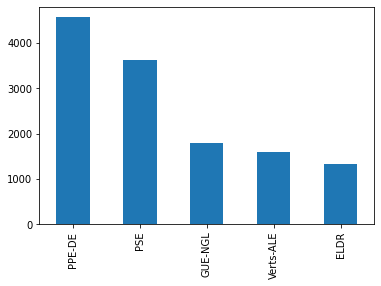

In [ ]:
train_df['y_train'].value_counts().plot.bar()

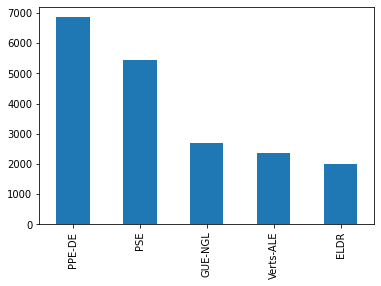

In [ ]:
test_df['y_test'].value_counts().plot.bar()

In [ ]:
# shuffle the DataFrame rows
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
# Drop Na
train_df = train_df.dropna()
test_df = test_df.dropna()

# Tokenize via vectorization
train_df["x_train_tokens"] = train_df["x_train"].apply(word_tokenize)
test_df["x_test_tokens"] =   test_df["x_test"].apply(word_tokenize)

# Remove stop words
def remove_stop_words(tokens):
  for token in tokens:
      if token in stopwords.words(LANG):
          tokens.remove(token)
  return tokens
train_df["x_train_cleaned"] = train_df["x_train_tokens"].progress_apply(remove_stop_words)
test_df["x_test_cleaned"] = test_df["x_test_tokens"].progress_apply(remove_stop_words)

100%|██████████| 19370/19370 [06:21<00:00, 50.83it/s]


Let's inspect our cleaned dataset and vectorize using a transformer.

In [ ]:
train_df.head()

,x_train,y_train,x_train_tokens,x_train_cleaned
11500,\nmr president i should first of all like to c...,ELDR,"[mr, president, first, all, like, congratulate...","[mr, president, first, all, like, congratulate..."
6145,\nmr president commissioner a great deal has b...,PPE-DE,"[mr, president, commissioner, great, deal, bee...","[mr, president, commissioner, great, deal, bee..."
1618,\nmr president commissioner ladies and gentlem...,Verts-ALE,"[mr, president, commissioner, ladies, gentleme...","[mr, president, commissioner, ladies, gentleme..."
11936,\nmadam president as regards fishing in intern...,Verts-ALE,"[madam, president, regards, fishing, internati...","[madam, president, regards, fishing, internati..."
9534,\nmadam president mrs reding allow me to congr...,PPE-DE,"[madam, president, mrs, reding, allow, congrat...","[madam, president, mrs, reding, allow, congrat..."


In [ ]:
test_df.head()

,x_test,y_test,x_test_tokens,x_test_cleaned
1773,\nincreased trade constitutes the developing c...,PPE-DE,"[increased, trade, constitutes, developing, co...","[increased, trade, constitutes, developing, co..."
16110,\nmr president the international afghanistan c...,PPE-DE,"[mr, president, international, afghanistan, co...","[mr, president, international, afghanistan, co..."
16720,\nmr president mr ebner i would like at this j...,ELDR,"[mr, president, mr, ebner, would, like, this, ...","[mr, president, mr, ebner, would, like, this, ..."
8414,\nmr president i start with the commissions wo...,PPE-DE,"[mr, president, start, commissions, work, prog...","[mr, president, start, commissions, work, prog..."
2061,\nmr president commissioner ladies and gentlem...,PPE-DE,"[mr, president, commissioner, ladies, gentleme...","[mr, president, commissioner, ladies, gentleme..."


# Vectorize with transformer
The paragraphs look pretty good. We can preprocess a bit further as well but  we have applied the basics such as removing stopwords and tokenizing, we'll attempt to get an intial benchmark of the sentence classification using an svc.

In [ ]:
# load one of the models listed at https://github.com/MartinoMensio/spacy-sentence-bert/
nlp = spacy_sentence_bert.load_model('en_stsb_distilbert_base')

Downloading:   0%|          | 0.00/523 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Since we don't have good GPUs we will only sample for the first 5000. Usually we would want to randomly sample to decide.

In [ ]:
# After loading the transformer, we'll vectorize our sentences, it may take a while
"""
We recommend running this on a GPU for faster processing, 
according to TQDM, it should take around 2 Minutes.
"""

# First convert list of strings to strings, to allow for vectorization
# Function to convert 
def list_to_string(s):
   
    # initialize an empty string
    str1 = " "
   
    # return string 
    return (str1.join(s))
train_df["x_train_final"] = train_df["x_train_cleaned"].apply(list_to_string)
test_df["x_test_final"] = test_df["x_test_cleaned"].apply(list_to_string)

In [ ]:
# Finally we'll vectorize approx 8 

def vectorize(string):
  return nlp(string).vector
train_df["x_train_vector"] = train_df["x_train_final"].progress_apply(vectorize)
test_df["x_test_vector"] = test_df["x_test_final"].progress_apply(vectorize)

100%|██████████| 19370/19370 [02:40<00:00, 120.65it/s]


In [ ]:
print(type(train_df["x_train_final"][0]))
print(train_df["x_train_final"][0])
train_df.head()

<class 'str'>
mr president would like propose oral amendment concerning paragraph 34 fact shall propose fundamental changes just matter linking several amendments take account new considerations apply following tabling draft report namely peace proposals secretarygeneral united nations would propose keeping paragraph 34 appears draft text adding amendment 42 text paragraph 34 simply inserting words welcomes it this context for the rest amendment 42 it would remain is the words this context would added in other words simple link the second part amendment 9 the could considered an addition well the second part amendment 12 the would also be an addition amendments compatible the president established at least 32 members objected the oral amendment


,x_train,y_train,x_train_tokens,x_train_cleaned,x_train_final,x_train_vector
11500,\nmr president i should first of all like to c...,ELDR,"[mr, president, first, all, like, congratulate...","[mr, president, first, all, like, congratulate...",mr president first all like congratulate mr bo...,"[-0.23920406, 0.23644824, 0.31777143, 0.108142..."
6145,\nmr president commissioner a great deal has b...,PPE-DE,"[mr, president, commissioner, great, deal, bee...","[mr, president, commissioner, great, deal, bee...",mr president commissioner great deal been said...,"[0.0051166187, 0.01879533, 0.43873557, 0.22648..."
1618,\nmr president commissioner ladies and gentlem...,Verts-ALE,"[mr, president, commissioner, ladies, gentleme...","[mr, president, commissioner, ladies, gentleme...",mr president commissioner ladies gentlemen ado...,"[0.28733516, 0.36492366, 0.20879905, -0.083152..."
11936,\nmadam president as regards fishing in intern...,Verts-ALE,"[madam, president, regards, fishing, internati...","[madam, president, regards, fishing, internati...",madam president regards fishing international ...,"[0.08269194, 0.08501364, 0.23561692, -0.347849..."
9534,\nmadam president mrs reding allow me to congr...,PPE-DE,"[madam, president, mrs, reding, allow, congrat...","[madam, president, mrs, reding, allow, congrat...",madam president mrs reding allow congratulate ...,"[0.9778119, -0.043685034, 0.018418487, 0.41551..."


## Training the dataset

In [ ]:
# For each of the features we'll apply 
# Support Vector Machine
clf = SVC(gamma='auto', verbose=True) 
clf.fit(train_df["x_train_vector"].to_list(),train_df["y_train"].to_list())
y_pred = clf.predict(test_df["x_test_vector"].to_list())
print(f'Our accuracy is: {np.round(accuracy_score(test_df["y_test"].to_list(), y_pred)*100, decimals=4)}%')

[LibSVM]Our accuracy is: 40.9138%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# For each of the features we'll apply 
# RandomForest
clf = RandomForestClassifier(max_depth=None, random_state=0)
clf.fit(train_df["x_train_vector"].to_list(),train_df["y_train"].to_list())
y_pred = clf.predict(test_df["x_test_vector"].to_list())
print(f'Our accuracy is: {np.round(accuracy_score(test_df["y_test"].to_list(), y_pred)*100, decimals=4)}%')

Our accuracy is: 63.3764%


In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import OneHotEncoder

# For each of the features we'll apply 
# LogisticRegression
clf = LogisticRegression(max_iter=5000)
clf.fit(train_df["x_train_vector"].to_list(),train_df["y_train"].to_list())
y_pred = clf.predict(test_df["x_test_vector"].to_list())
print(f'Our accuracy is: {np.round(accuracy_score(test_df["y_test"].to_list(), y_pred)*100, decimals=4)}%')

Our accuracy is: 44.9768%


In [ ]:
#from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

# For each of the features we'll apply 
# Naive Bayes
clf = GaussianNB()
clf.fit(train_df["x_train_vector"].to_list(),train_df["y_train"].to_list())
y_pred = clf.predict(test_df["x_test_vector"].to_list())
print(f'Our accuracy is: {np.round(accuracy_score(test_df["y_test"].to_list(), y_pred)*100, decimals=4)}%')

Our accuracy is: 31.0996%


# Further work

Further work can be accomplished to improve the model such as dimensionality reduction, feature engineering and using better state-of-the-art transformers and larger GPUs.